# IMPORT ALL LIBRARIES

In [5]:
# ALL IMPORTS
import os
import tarfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
from pandas.plotting import scatter_matrix
from scipy.stats import randint
from sklearn import set_config
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    StratifiedShuffleSplit,
    train_test_split,
    cross_val_score,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows', None)

In [2]:
set_config(display="diagram")

# Load Data
[Download_Dataset](https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing/housing.tgz)

In [6]:
with tarfile.open("../data/raw/housing.tgz", "r:*") as tar:
    csv_path = tar.getnames()[0]
    housing = pd.read_csv(tar.extractfile(csv_path), header=0, sep=",")

print("Shape of the data:",housing.shape)
housing.head()

Shape of the data: (20640, 10)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


# DEFINING ALL FUNCTIONS

In [4]:
# Function to give proportions of unique income_cat column in the given dataset
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

In [5]:
# Function to display the scores of different models
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

# EXPLORATORY DATA ANALYSIS (EDA)
### ON WHOLE DATA

In [6]:
print(housing.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB
None


In [7]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [8]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [9]:
housing.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

array([[<AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'housing_median_age'}>],
       [<AxesSubplot:title={'center':'total_rooms'}>,
        <AxesSubplot:title={'center':'total_bedrooms'}>,
        <AxesSubplot:title={'center':'population'}>],
       [<AxesSubplot:title={'center':'households'}>,
        <AxesSubplot:title={'center':'median_income'}>,
        <AxesSubplot:title={'center':'median_house_value'}>]],
      dtype=object)

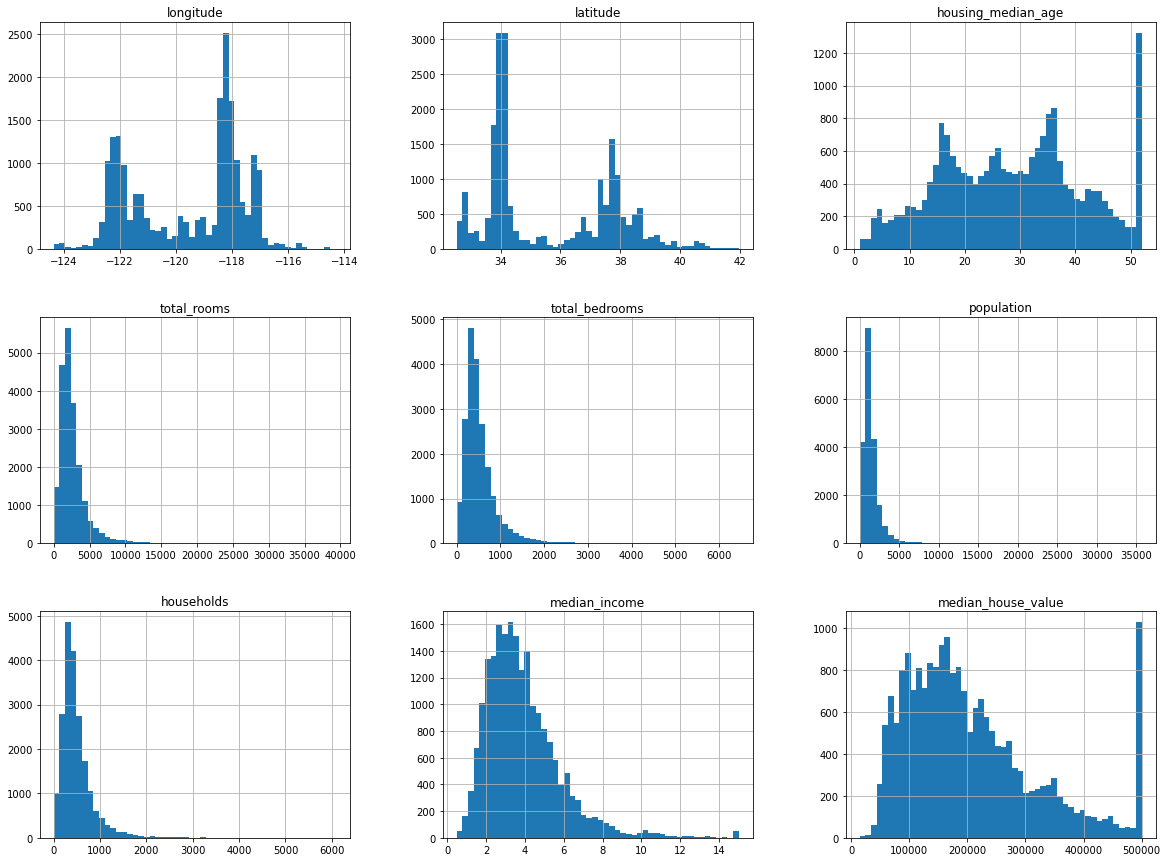

In [10]:
# The distributions of all attributes
%matplotlib inline
housing.hist(bins=50, figsize=(20,15))

<AxesSubplot:>

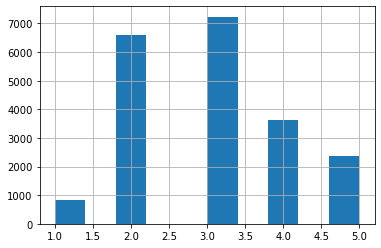

In [11]:
# Bucketing income in income categories
housing["income_cat"] = pd.cut(housing["median_income"], bins=[0.0, 1.5, 3.0, 4.5, 6.0, np.inf], labels=[1, 2, 3, 4, 5])

# The distibution of attribute "income_cat"
housing["income_cat"].hist()

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

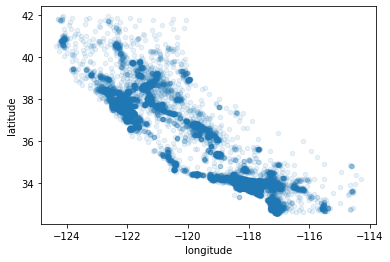

In [12]:
# Relation between "longitude" & "latitude"
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

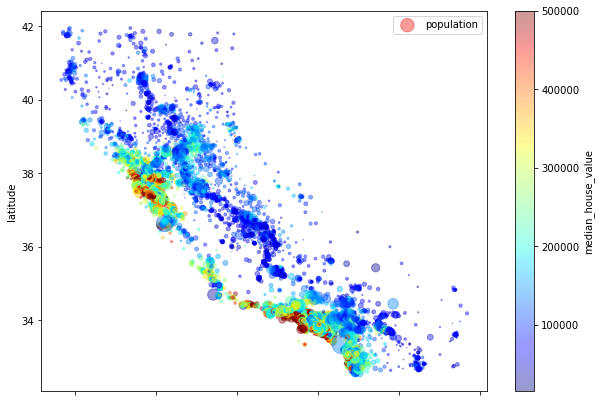

In [13]:
# Relation between price of house with location and population dencity
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, s=housing["population"]/100, label="population", 
             figsize=(10,7), c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,)

plt.legend()

* **Image-Info:** Red is expensive, blue is cheap, larger circles indicate areas with a larger population
* **Conclusion:** The housing prices are very much related to the location (close to the ocean) and to the population density

## CORRELATION MATRICES ANALYSIS

<AxesSubplot:>

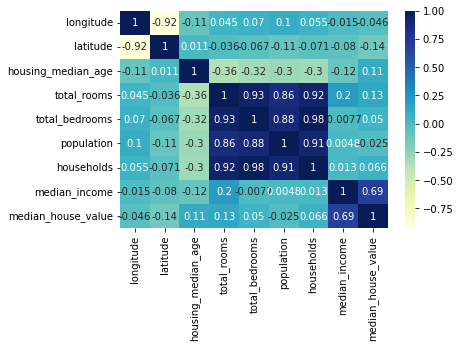

In [14]:
# Heatmap
sb.heatmap(housing.corr(), cmap="YlGnBu", annot=True)

array([[<AxesSubplot:xlabel='longitude', ylabel='longitude'>,
        <AxesSubplot:xlabel='latitude', ylabel='longitude'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='longitude'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='longitude'>,
        <AxesSubplot:xlabel='total_bedrooms', ylabel='longitude'>,
        <AxesSubplot:xlabel='population', ylabel='longitude'>,
        <AxesSubplot:xlabel='households', ylabel='longitude'>,
        <AxesSubplot:xlabel='median_income', ylabel='longitude'>,
        <AxesSubplot:xlabel='median_house_value', ylabel='longitude'>],
       [<AxesSubplot:xlabel='longitude', ylabel='latitude'>,
        <AxesSubplot:xlabel='latitude', ylabel='latitude'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='latitude'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='latitude'>,
        <AxesSubplot:xlabel='total_bedrooms', ylabel='latitude'>,
        <AxesSubplot:xlabel='population', ylabel='latitude'>,
        <AxesSubplot:xlabel='

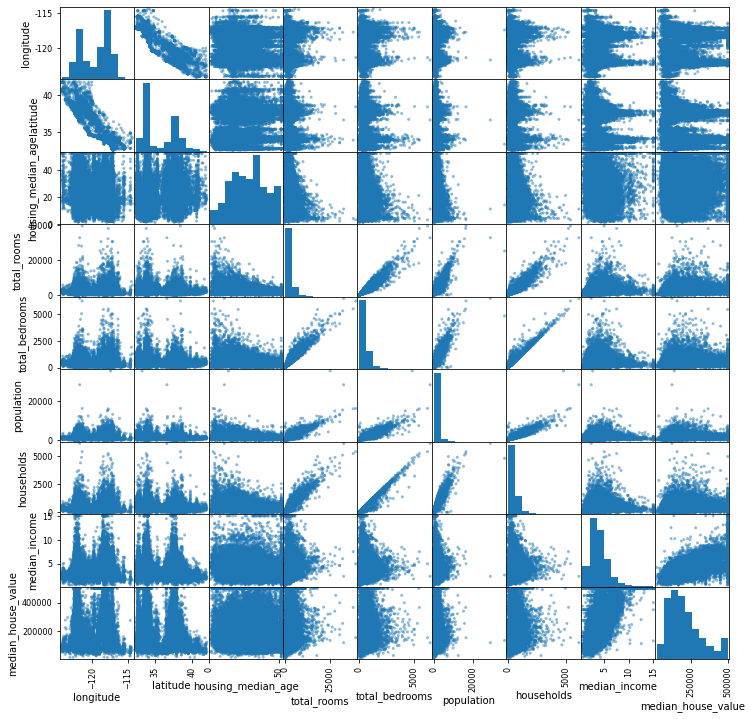

In [15]:
# Correalation with distribution of data
scatter_matrix(housing, figsize=(12, 12))

In [16]:
# Sorted Correlation of attributes with price of house
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

## EXPEREMENTING WITH ATTRIBUTE COMBINATIONS

In [17]:
# New Attributes
housing["rooms_per_household"]      = housing["total_rooms"]    / housing["households"]
housing["bedrooms_per_room"]        = housing["total_bedrooms"] / housing["total_rooms"]
housing["population_per_household"] = housing["population"]     / housing["households"]

<AxesSubplot:>

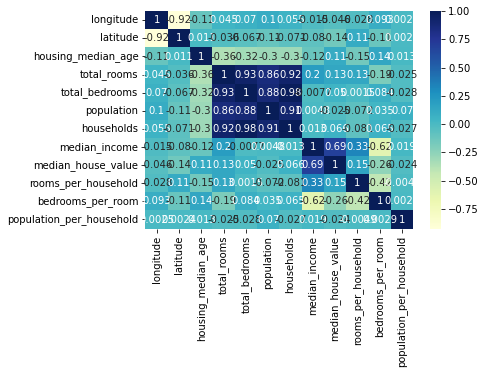

In [18]:
# Heatmap
sb.heatmap(housing.corr(), cmap="YlGnBu", annot=True)

array([[<AxesSubplot:xlabel='longitude', ylabel='longitude'>,
        <AxesSubplot:xlabel='latitude', ylabel='longitude'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='longitude'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='longitude'>,
        <AxesSubplot:xlabel='total_bedrooms', ylabel='longitude'>,
        <AxesSubplot:xlabel='population', ylabel='longitude'>,
        <AxesSubplot:xlabel='households', ylabel='longitude'>,
        <AxesSubplot:xlabel='median_income', ylabel='longitude'>,
        <AxesSubplot:xlabel='median_house_value', ylabel='longitude'>,
        <AxesSubplot:xlabel='rooms_per_household', ylabel='longitude'>,
        <AxesSubplot:xlabel='bedrooms_per_room', ylabel='longitude'>,
        <AxesSubplot:xlabel='population_per_household', ylabel='longitude'>],
       [<AxesSubplot:xlabel='longitude', ylabel='latitude'>,
        <AxesSubplot:xlabel='latitude', ylabel='latitude'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='latitude'>,
 

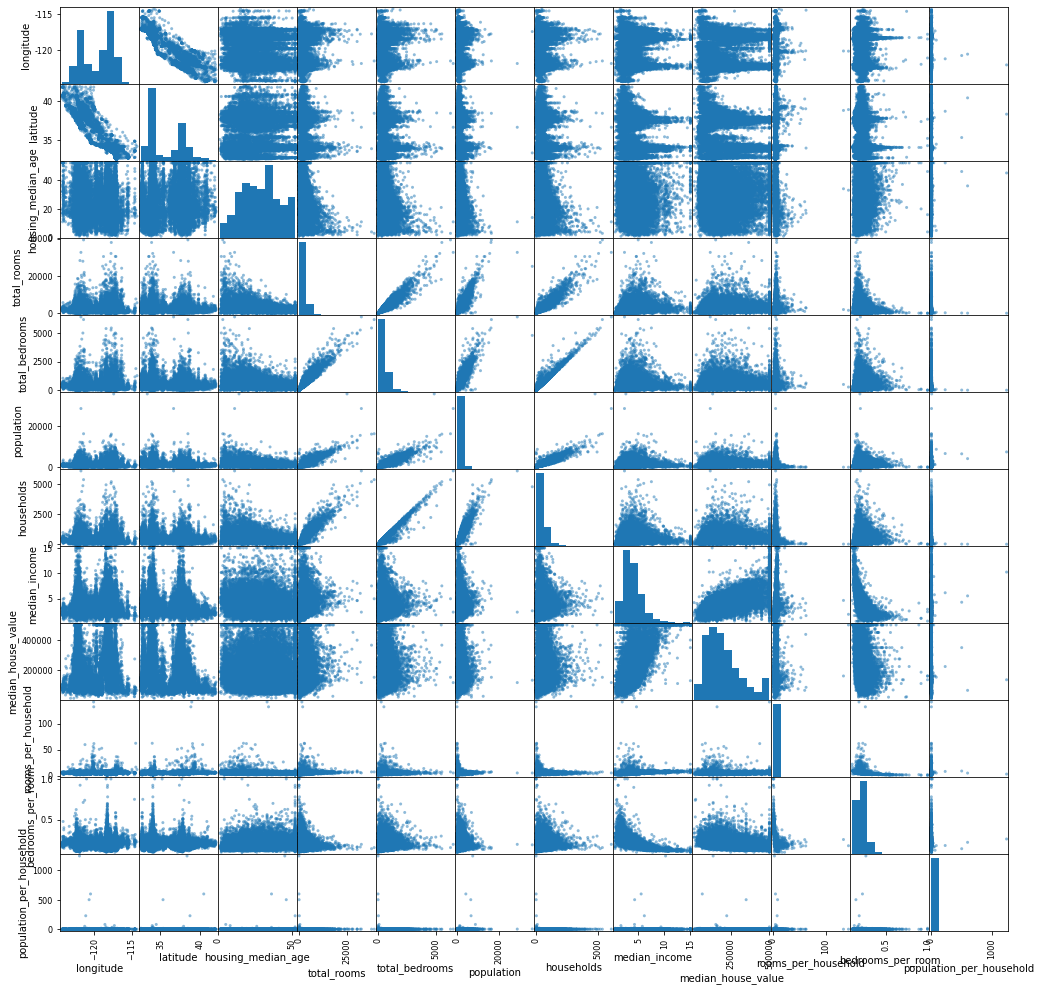

In [19]:
# Correalation with distribution of data
scatter_matrix(housing, figsize=(17, 17))

In [20]:
# Sorted Correlation of attributes with price of house
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.688075
rooms_per_household         0.151948
total_rooms                 0.134153
housing_median_age          0.105623
households                  0.065843
total_bedrooms              0.049686
population_per_household   -0.023737
population                 -0.024650
longitude                  -0.045967
latitude                   -0.144160
bedrooms_per_room          -0.255880
Name: median_house_value, dtype: float64

# TRAIN - TEST SPLIT

We are using two ifferent types of split to split the data. Ratio was kept same as 80:20
1. Random Split
2. Stratified Shuffle Split

In [21]:
# Random Split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
print(train_set.shape)
print(test_set.shape)

(16512, 14)
(4128, 14)


In [22]:
# Stratified Shuffle Split
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    start_train_set = housing.loc[train_index]
    start_test_set = housing.loc[test_index]
    
print(start_train_set.shape)
print(start_test_set.shape)

(16512, 14)
(4128, 14)


In [23]:
# Calling the function "income_cat_proportions"
compare_props = pd.DataFrame(
    {
        "Overall": income_cat_proportions(housing),
        "Stratified": income_cat_proportions(start_test_set),
        "Random": income_cat_proportions(test_set),
    }
).sort_index()

print(compare_props)

    Overall  Stratified    Random
1  0.039826    0.039729  0.040213
2  0.318847    0.318798  0.324370
3  0.350581    0.350533  0.358527
4  0.176308    0.176357  0.167393
5  0.114438    0.114583  0.109496


In [24]:
# Compairing %error of both types of split

# Random Split
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100

# Stratified Shuffle Split
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

print(compare_props)

    Overall  Stratified    Random  Rand. %error  Strat. %error
1  0.039826    0.039729  0.040213      0.973236      -0.243309
2  0.318847    0.318798  0.324370      1.732260      -0.015195
3  0.350581    0.350533  0.358527      2.266446      -0.013820
4  0.176308    0.176357  0.167393     -5.056334       0.027480
5  0.114438    0.114583  0.109496     -4.318374       0.127011


**Conclusion:** Stratified Shuffle Split has %erros nearly equal to 0, much less than Random Split.
                So we kept Stratified Shuffle Split as our final split.

In [25]:
# Dropping income_cat column from train and test dataset
for set_ in (start_train_set, start_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [26]:
train = start_train_set.copy()

# EXPLORATORY DATA ANALYSIS (EDA)
### ON TEST DATA

In [27]:
train = start_train_set.drop("median_house_value", axis=1)  # drop labels for training set
train_labels = start_train_set["median_house_value"].copy()

In [28]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 17606 to 15775
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   longitude                 16512 non-null  float64
 1   latitude                  16512 non-null  float64
 2   housing_median_age        16512 non-null  float64
 3   total_rooms               16512 non-null  float64
 4   total_bedrooms            16354 non-null  float64
 5   population                16512 non-null  float64
 6   households                16512 non-null  float64
 7   median_income             16512 non-null  float64
 8   ocean_proximity           16512 non-null  object 
 9   rooms_per_household       16512 non-null  float64
 10  bedrooms_per_room         16354 non-null  float64
 11  population_per_household  16512 non-null  float64
dtypes: float64(11), object(1)
memory usage: 1.6+ MB


In [29]:
# Null values in all columns
train.isna().sum()

longitude                     0
latitude                      0
housing_median_age            0
total_rooms                   0
total_bedrooms              158
population                    0
households                    0
median_income                 0
ocean_proximity               0
rooms_per_household           0
bedrooms_per_room           158
population_per_household      0
dtype: int64

# TRAIN DATA PREPRATION

In [30]:
# Filling all null values
imputer = SimpleImputer(strategy="median")

train_num = train.drop("ocean_proximity", axis=1)

imputer.fit(train_num)            # Find the Meadian of respective columns
X = imputer.transform(train_num)  # Repalce all null valus with Median of the respective columns

In [31]:
train_tr = pd.DataFrame(X, columns=train_num.columns, index=train.index)

In [32]:
# After impution there are no null values
train_tr.isna().sum()

longitude                   0
latitude                    0
housing_median_age          0
total_rooms                 0
total_bedrooms              0
population                  0
households                  0
median_income               0
rooms_per_household         0
bedrooms_per_room           0
population_per_household    0
dtype: int64

In [33]:
housing_cat = train[["ocean_proximity"]]

In [34]:
housing_cat.head()

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN


In [35]:
# Convert text valus to numbers
# Final Training dataset prepared
train_prepared = train_tr.join(pd.get_dummies(housing_cat, drop_first=True))

In [36]:
train_prepared.shape

(16512, 15)

In [37]:
train_prepared.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_household,bedrooms_per_room,population_per_household,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,4.625369,0.223852,2.094395,0,0,0,0
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,6.008850,0.159057,2.707965,0,0,0,0
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,4.225108,0.241291,2.025974,0,0,0,1
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,5.232295,0.200866,4.135977,1,0,0,0
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,4.505810,0.231341,3.047847,0,0,0,0


In [38]:
train_prepared.isna().sum()

longitude                     0
latitude                      0
housing_median_age            0
total_rooms                   0
total_bedrooms                0
population                    0
households                    0
median_income                 0
rooms_per_household           0
bedrooms_per_room             0
population_per_household      0
ocean_proximity_INLAND        0
ocean_proximity_ISLAND        0
ocean_proximity_NEAR BAY      0
ocean_proximity_NEAR OCEAN    0
dtype: int64

**Conclusion**: Training data is prepared

# TEST DATA PREPRATION

In [39]:
test = start_test_set.drop("median_house_value", axis=1)

test_lables = start_test_set["median_house_value"].copy()

test_num = test.drop("ocean_proximity", axis=1)

test_prepared = imputer.transform(test_num)
test_prepared = pd.DataFrame(test_prepared, columns=test_num.columns, index=test.index)

X_test_cat = test[["ocean_proximity"]]

test_prepared = test_prepared.join(pd.get_dummies(X_test_cat, drop_first=True))

In [40]:
test_prepared.shape

(4128, 15)

In [41]:
test_prepared.isna().sum()

longitude                     0
latitude                      0
housing_median_age            0
total_rooms                   0
total_bedrooms                0
population                    0
households                    0
median_income                 0
rooms_per_household           0
bedrooms_per_room             0
population_per_household      0
ocean_proximity_INLAND        0
ocean_proximity_ISLAND        0
ocean_proximity_NEAR BAY      0
ocean_proximity_NEAR OCEAN    0
dtype: int64

**Conclusion:** Test data is prepared

# MODELLING AND FITTING

we are using four different regression models.
1. Linear Regression
2. Decision Tree Regressor
3. Random Forest Regressor
4. SVR

## 1. Linear Regression Model

### TRAINING & FITTING

In [42]:
lin_reg = LinearRegression()
lin_reg.fit(train_prepared, train_labels)

LinearRegression()

### PREDICTION

In [43]:
lin_reg_housing_predictions = lin_reg.predict(test_prepared)

### GENERAL SCORING

In [44]:
lin_mae = mean_absolute_error(test_lables, lin_reg_housing_predictions)
lin_mse = mean_squared_error(test_lables, lin_reg_housing_predictions)
lin_rmse = np.sqrt(lin_mse)

print(lin_mae)
print(lin_mse)
print(lin_rmse)

48960.517227369826
4462487690.346743
66801.85394393439


### K FOLD SCORING 
**Note:** The following code randomly splits the training set into 10 distinct subsets called folds, then it trains and evaluates the Decision Tree model 10 times, picking a different fold for evaluation every time and training on the other 9 folds. The result is an array containing the 10 evaluation scores:

In [45]:
scores = cross_val_score(lin_reg, train_prepared, train_labels, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-scores)

# Calling Function "display_scores"
display_scores(lin_rmse_scores)

Scores: [66060.65470195 66764.30726969 67721.72734022 74719.28193624
 68058.11572078 70909.35812986 64171.66459204 68075.65317717
 71024.84033989 67300.24394751]
Mean: 68480.58471553585
Standard deviation: 2845.5843092646883


## 2. Decision Tree Regressor Model

### TRAINING & FITTING

In [46]:
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(train_prepared, train_labels)

DecisionTreeRegressor(random_state=42)

### PREDICTION

In [47]:
tree_reg_housing_predictions = tree_reg.predict(test_prepared)

### GENERAL SCORING

In [48]:
tree_mae = mean_absolute_error(test_lables, tree_reg_housing_predictions)
tree_mse = mean_squared_error(test_lables, tree_reg_housing_predictions)
tree_rmse = np.sqrt(tree_mse)

print(tree_mae)
print(tree_mse)
print(tree_rmse)

45065.935562015504
4811132039.724321
69362.32435353014


### K FOLD SCORING 

In [49]:
scores = cross_val_score(tree_reg, train_prepared, train_labels, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

# Calling Function "display_scores"
display_scores(tree_rmse_scores)

Scores: [71737.95978173 67434.9158851  71194.32345253 69695.63452525
 69050.95653901 75103.40194402 69687.09637898 69337.05653026
 76339.28190417 70567.75435694]
Mean: 71014.83812979834
Standard deviation: 2623.2018785726727


## 3. Random Forest Regressor Model

### TRAINING & FITTING

In [50]:
forest_reg = RandomForestRegressor()
forest_reg.fit(train_prepared, train_labels)

RandomForestRegressor()

### PREDICTION

In [51]:
tree_reg_housing_predictions = tree_reg.predict(test_prepared)

### GENERAL SCORING

In [52]:
Forest_mae = mean_absolute_error(test_lables, tree_reg_housing_predictions)
Forest_mse = mean_squared_error(test_lables, tree_reg_housing_predictions)
Forest_rmse = np.sqrt(tree_mse)

print(Forest_mae)
print(Forest_mse)
print(Forest_rmse)

45065.935562015504
4811132039.724321
69362.32435353014


### K FOLD SCORING

In [53]:
scores = cross_val_score(forest_reg, train_prepared, train_labels, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-scores)

# Calling Function "display_scores"
display_scores(tree_rmse_scores)

Scores: [71737.95978173 67434.9158851  71194.32345253 69695.63452525
 69050.95653901 75103.40194402 69687.09637898 69337.05653026
 76339.28190417 70567.75435694]
Mean: 71014.83812979834
Standard deviation: 2623.2018785726727


## HYPERPARAMETER TUNING

We are using two types of CV to find best parameters.
1. GridSearchCV
2. RandomizedSearchCV

## 1. GridSearchCV

In [54]:
forest_reg = RandomForestRegressor(random_state=42)

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {"n_estimators": [3, 10, 30], "max_features": [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {"bootstrap": [False], "n_estimators": [3, 10], "max_features": [2, 3, 4]},
]

# train across 5 folds, that's a total of (12+6)*5=90 rounds of training

grid_search = GridSearchCV(forest_reg, 
                           param_grid, 
                           cv=5, 
                           scoring="neg_mean_squared_error", 
                           return_train_score=True,)

grid_search.fit(train_prepared, train_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [55]:
# Best Params to train the model
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [56]:
cvres = grid_search.cv_results_

# Scores for all GridSearchCV combinations
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print("grid_search_cv", np.sqrt(-mean_score), params)

grid_search_cv 65522.27361164929 {'max_features': 2, 'n_estimators': 3}
grid_search_cv 55988.46465850714 {'max_features': 2, 'n_estimators': 10}
grid_search_cv 53133.316978932664 {'max_features': 2, 'n_estimators': 30}
grid_search_cv 59329.25217629036 {'max_features': 4, 'n_estimators': 3}
grid_search_cv 52853.87870456959 {'max_features': 4, 'n_estimators': 10}
grid_search_cv 50402.64543210117 {'max_features': 4, 'n_estimators': 30}
grid_search_cv 58732.239295172214 {'max_features': 6, 'n_estimators': 3}
grid_search_cv 52335.420580626196 {'max_features': 6, 'n_estimators': 10}
grid_search_cv 50031.95571076959 {'max_features': 6, 'n_estimators': 30}
grid_search_cv 58035.64675283708 {'max_features': 8, 'n_estimators': 3}
grid_search_cv 51625.49406488196 {'max_features': 8, 'n_estimators': 10}
grid_search_cv 50194.19748928249 {'max_features': 8, 'n_estimators': 30}
grid_search_cv 63521.42146846016 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
grid_search_cv 54908.156829342945

In [57]:
# Feature Importance
feature_importance_scores = grid_search.best_estimator_.feature_importances_

sorted(zip(feature_importance_scores, train_prepared.columns.values), reverse=True)

[(0.3372547387377288, 'median_income'),
 (0.15104790403295212, 'ocean_proximity_INLAND'),
 (0.11307169778949921, 'population_per_household'),
 (0.07733623442417746, 'longitude'),
 (0.07663687839277437, 'bedrooms_per_room'),
 (0.07354595635470701, 'latitude'),
 (0.05864356452444516, 'rooms_per_household'),
 (0.04303800120792018, 'housing_median_age'),
 (0.016997455483388667, 'total_rooms'),
 (0.016267160382887922, 'population'),
 (0.015279600757524011, 'total_bedrooms'),
 (0.015053577671013592, 'households'),
 (0.003652167349863969, 'ocean_proximity_NEAR OCEAN'),
 (0.002149505158094662, 'ocean_proximity_NEAR BAY'),
 (2.555773302267819e-05, 'ocean_proximity_ISLAND')]

### TRAINING & FITTING OF TUNED MODEL

In [58]:
tuned_forest_reg = RandomForestRegressor(bootstrap=True, 
                                         criterion='mse', 
                                         max_depth=None,
                                         max_features=6, 
                                         max_leaf_nodes=None, 
                                         min_impurity_decrease=0.0,
                                         min_impurity_split=None, 
                                         min_samples_leaf=1,
                                         min_samples_split=2, 
                                         min_weight_fraction_leaf=0.0,
                                         n_estimators=30, 
                                         n_jobs=None, 
                                         oob_score=False, 
                                         random_state=None,
                                         verbose=0, 
                                         warm_start=False)

tuned_forest_reg.fit(train_prepared, train_labels)

RandomForestRegressor(max_features=6, n_estimators=30)

### PREDICTION OF TUNED MODEL

In [59]:
tuned_tree_reg_housing_predictions = tuned_forest_reg.predict(test_prepared)

### GENERAL SCORING OF TUNED MODEL

In [60]:
tuned_Forest_mae = mean_absolute_error(test_lables, tuned_tree_reg_housing_predictions)
tuned_Forest_mse = mean_squared_error(test_lables, tuned_tree_reg_housing_predictions)
tuned_Forest_rmse = np.sqrt(tuned_Forest_mse)

print(tuned_Forest_mae)
print(tuned_Forest_mse)
print(tuned_Forest_rmse)

32249.363735465115
2317771989.8137565
48143.244487817356


### K FOLD SCORING OF TUNED MODEL

In [61]:
scores = cross_val_score(tuned_forest_reg, train_prepared, train_labels, scoring="neg_mean_squared_error", cv=10)
tuned_forest_rmse_scores = np.sqrt(-scores)

# Calling Function "display_scores"
display_scores(tuned_forest_rmse_scores)

Scores: [49249.94298983 47554.51655294 49350.23458509 51500.49574191
 48403.99773866 53907.93785615 47496.22318109 47703.21363424
 51474.28671316 50092.86748918]
Mean: 49673.371648225744
Standard deviation: 1992.3671782620995


## 2. RandomizedSearchCV

In [62]:
forest_reg = RandomForestRegressor(random_state=42)

param_distribs = {
    "n_estimators": randint(low=1, high=200),
    "max_features": randint(low=1, high=8),
}

rnd_search = RandomizedSearchCV(forest_reg, 
                                param_distributions=param_distribs, 
                                n_iter=10, cv=5,
                                scoring="neg_mean_squared_error",
                                random_state=42,)

rnd_search.fit(train_prepared, train_labels)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000019EA1C35E20>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000019EA1C3E8B0>},
                   random_state=42, scoring='neg_mean_squared_error')

In [63]:
# Best Params to train the model
rnd_search.best_params_

{'max_features': 7, 'n_estimators': 180}

In [64]:
cvres = rnd_search.cv_results_

# Scores for all GridSearchCV combinations
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print("rnd_search_cv", np.sqrt(-mean_score), params)

rnd_search_cv 49166.57396706314 {'max_features': 7, 'n_estimators': 180}
rnd_search_cv 51094.409720335796 {'max_features': 5, 'n_estimators': 15}
rnd_search_cv 50524.64054885866 {'max_features': 3, 'n_estimators': 72}
rnd_search_cv 50345.29113226761 {'max_features': 5, 'n_estimators': 21}
rnd_search_cv 49332.6925050635 {'max_features': 7, 'n_estimators': 122}
rnd_search_cv 50549.08787718249 {'max_features': 3, 'n_estimators': 75}
rnd_search_cv 50447.656200976664 {'max_features': 3, 'n_estimators': 88}
rnd_search_cv 49436.24699495027 {'max_features': 5, 'n_estimators': 100}
rnd_search_cv 50330.88288381925 {'max_features': 3, 'n_estimators': 150}
rnd_search_cv 63794.78971545743 {'max_features': 5, 'n_estimators': 2}


In [65]:
feature_importance_scores = rnd_search.best_estimator_.feature_importances_

sorted(zip(feature_importance_scores, train_prepared.columns.values), reverse=True)

[(0.34939924412401535, 'median_income'),
 (0.1662450141535775, 'ocean_proximity_INLAND'),
 (0.11256033136050529, 'population_per_household'),
 (0.07046263865418569, 'bedrooms_per_room'),
 (0.06845395601564014, 'longitude'),
 (0.06681268676260377, 'latitude'),
 (0.055347408115170464, 'rooms_per_household'),
 (0.043686460202498736, 'housing_median_age'),
 (0.015812986552360193, 'total_rooms'),
 (0.015604957891728072, 'population'),
 (0.015177647132041536, 'total_bedrooms'),
 (0.014607738647042283, 'households'),
 (0.0036097248499540194, 'ocean_proximity_NEAR OCEAN'),
 (0.0021315043206143786, 'ocean_proximity_NEAR BAY'),
 (8.770121806272453e-05, 'ocean_proximity_ISLAND')]

<h1 style="text-align: center;">EXERCISES</h1>

# EXERCISE 1: 
Try a Support Vector Machine regressor (sklearn.svm.SVR) with various hyperparameters, such as kernel="linear" (with various values for the C hyperparameter) or kernel="rbf" (with various values for the C and gamma hyperparameters). Don’t worry about what these hyperparameters mean for now. How does the best SVR predictor perform?

## 4. SVR Regression Model

### TRAINING & FITTING

In [66]:
svm_reg = SVR(kernel = 'rbf')
svm_reg.fit(train_prepared, train_labels)

SVR()

### PREDICTION

In [67]:
svm_reg_housing_predictions = svm_reg.predict(test_prepared)

### GENERAL SCORING

In [68]:
SVM_mae = mean_absolute_error(test_lables, svm_reg_housing_predictions)
SVM_mse = mean_squared_error(test_lables, svm_reg_housing_predictions)
SVM_rmse = np.sqrt(SVM_mse)

print(SVM_mae)
print(SVM_mse)
print(SVM_rmse)

88172.75418136157
13736791725.03366
117204.06019005341


### K FOLD SCORING

In [69]:
scores = cross_val_score(svm_reg, train_prepared, train_labels, scoring="neg_mean_squared_error", cv=10)
svm_rmse_scores = np.sqrt(-scores)

# Calling Function "display_scores"
display_scores(tree_rmse_scores)

Scores: [71737.95978173 67434.9158851  71194.32345253 69695.63452525
 69050.95653901 75103.40194402 69687.09637898 69337.05653026
 76339.28190417 70567.75435694]
Mean: 71014.83812979834
Standard deviation: 2623.2018785726727


## HYPERPARAMETER TUNING

We are using two types of CV to find best parameters.
1. GridSearchCV
2. RandomizedSearchCV

## 1. GridSearchCV

In [70]:
SVM_reg = SVR()

param_grid = [{"kernel": ["rbf"], "gamma": [1, 0.01, 0.1], "C": [1, 10, 100]},
              {"kernel": ["linear"], "C": [1, 10, 100]}]


grid_search = GridSearchCV(SVM_reg, 
                           param_grid,  
                           cv=5, 
                           scoring="neg_mean_squared_error", 
                           return_train_score=True,
                           verbose = 2,)

grid_search.fit(train_prepared, train_labels)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=  58.9s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=  33.3s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=  35.4s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=  31.8s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=  25.3s
[CV] END ........................C=1, gamma=0.01, kernel=rbf; total time=  36.9s
[CV] END ........................C=1, gamma=0.01, kernel=rbf; total time=  25.1s
[CV] END ........................C=1, gamma=0.01, kernel=rbf; total time=  37.7s
[CV] END ........................C=1, gamma=0.01, kernel=rbf; total time=  27.2s
[CV] END ........................C=1, gamma=0.01, kernel=rbf; total time=  19.4s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=  19.6s
[CV] END .........................C=1, gamma=0.1

GridSearchCV(cv=5, estimator=SVR(),
             param_grid=[{'C': [1, 10, 100], 'gamma': [1, 0.01, 0.1],
                          'kernel': ['rbf']},
                         {'C': [1, 10, 100], 'kernel': ['linear']}],
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=2)

In [71]:
# Best Params to train the model
grid_best_params = grid_search.best_params_
print(grid_best_params)

{'C': 100, 'kernel': 'linear'}


In [72]:
# Best Params to train the model
grid_search.best_params_

{'C': 100, 'kernel': 'linear'}

In [73]:
grid_search.best_estimator_

SVR(C=100, kernel='linear')

In [74]:
cvres = grid_search.cv_results_

# Scores for all GridSearchCV combinations
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print("grid_search_cv", np.sqrt(-mean_score), params)

grid_search_cv 118923.18895218647 {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
grid_search_cv 118923.18671198573 {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
grid_search_cv 118923.18895378897 {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
grid_search_cv 118923.39871157857 {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
grid_search_cv 118923.37630946128 {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
grid_search_cv 118923.39872760426 {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
grid_search_cv 118925.49068062939 {'C': 100, 'gamma': 1, 'kernel': 'rbf'}
grid_search_cv 118925.30475876985 {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
grid_search_cv 118925.49084143594 {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
grid_search_cv 95550.51706671252 {'C': 1, 'kernel': 'linear'}
grid_search_cv 73822.44198245858 {'C': 10, 'kernel': 'linear'}
grid_search_cv 70513.01909841344 {'C': 100, 'kernel': 'linear'}


### TRAINING & FITTING OF TUNED MODEL

In [75]:
tuned_svm_reg = SVR(C = 100,
                    kernel = 'linear')

tuned_svm_reg.fit(train_prepared, train_labels)

SVR(C=100, kernel='linear')

### PREDICTION OF TUNED MODEL

In [76]:
tuned_svm_reg_housing_predictions = tuned_svm_reg.predict(test_prepared)

### GENERAL SCORING OF TUNED MODEL

In [77]:
tuned_svm_mae = mean_absolute_error(test_lables, tuned_svm_reg_housing_predictions)
tuned_svm_mse = mean_squared_error(test_lables, tuned_svm_reg_housing_predictions)
tuned_svm_rmse = np.sqrt(tuned_svm_mse)

print(tuned_svm_mae)
print(tuned_svm_mse)
print(tuned_svm_rmse)

48505.90372679585
4730069267.959199
68775.4990382418


# EXERCISE 2: 
Try replacing GridSearchCV with RandomizedSearchCV.

## 2. RandomizedSearchCV

In [ ]:
tuned_svm_reg = SVR()

param_distribs = [{"kernel": ["rbf"], "gamma": [1, 0.01, 0.1], "C": [1, 10, 100]},
                  {"kernel": ["linear"], "C": [1, 10, 100]}]

rnd_search = RandomizedSearchCV(tuned_svm_reg, param_distributions=param_distribs,
                                n_iter=50, cv=5, scoring='neg_mean_squared_error',
                                verbose=2, random_state=42)


rnd_search.fit(train_prepared, train_labels)

c:\Users\varsha.rajawat\.conda\envs\mle-dev\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 12 is smaller than n_iter=50. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=  34.3s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=  36.3s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time= 1.2min
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time= 1.2min
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time= 1.1min
[CV] END ........................C=1, gamma=0.01, kernel=rbf; total time=  36.8s
[CV] END ........................C=1, gamma=0.01, kernel=rbf; total time=  46.7s
[CV] END ........................C=1, gamma=0.01, kernel=rbf; total time=  30.1s
[CV] END ........................C=1, gamma=0.01, kernel=rbf; total time=  58.8s
[CV] END ........................C=1, gamma=0.01, kernel=rbf; total time= 1.8min
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time= 1.1min
[CV] END .........................C=1, gamma=0.1

RandomizedSearchCV(cv=5, estimator=SVR(), n_iter=50,
                   param_distributions=[{'C': [1, 10, 100],
                                         'gamma': [1, 0.01, 0.1],
                                         'kernel': ['rbf']},
                                        {'C': [1, 10, 100],
                                         'kernel': ['linear']}],
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [ ]:
# Best Params to train the model
rnd_best_params = rnd_search.best_params_
print(rnd_best_params)

{'kernel': 'linear', 'C': 100}


In [ ]:
rnd_search.best_estimator_

SVR(C=100, kernel='linear')

In [ ]:
cvres = rnd_search.cv_results_

# Scores for all GridSearchCV combinations
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print("grid_search_cv", np.sqrt(-mean_score), params)

grid_search_cv 118923.18895218647 {'kernel': 'rbf', 'gamma': 1, 'C': 1}
grid_search_cv 118923.18671198573 {'kernel': 'rbf', 'gamma': 0.01, 'C': 1}
grid_search_cv 118923.18895378897 {'kernel': 'rbf', 'gamma': 0.1, 'C': 1}
grid_search_cv 118923.39871157857 {'kernel': 'rbf', 'gamma': 1, 'C': 10}
grid_search_cv 118923.37630946128 {'kernel': 'rbf', 'gamma': 0.01, 'C': 10}
grid_search_cv 118923.39872760426 {'kernel': 'rbf', 'gamma': 0.1, 'C': 10}
grid_search_cv 118925.49068062939 {'kernel': 'rbf', 'gamma': 1, 'C': 100}
grid_search_cv 118925.30475876985 {'kernel': 'rbf', 'gamma': 0.01, 'C': 100}
grid_search_cv 118925.49084143594 {'kernel': 'rbf', 'gamma': 0.1, 'C': 100}
grid_search_cv 95550.51706671252 {'kernel': 'linear', 'C': 1}
grid_search_cv 73822.44198245858 {'kernel': 'linear', 'C': 10}
grid_search_cv 70513.01909841344 {'kernel': 'linear', 'C': 100}


### TRAINING & FITTING OF TUNED MODEL

In [ ]:
tuned_svm_reg = SVR(C = 100,
                    kernel = 'linear')

tuned_svm_reg.fit(train_prepared, train_labels)

SVR(C=100, kernel='linear')

### PREDICTION OF TUNED MODEL

In [ ]:
tuned_svm_reg_housing_predictions = tuned_svm_reg.predict(test_prepared)

### GENERAL SCORING OF TUNED MODEL

In [ ]:
tuned_svm_mae = mean_absolute_error(test_lables, tuned_svm_reg_housing_predictions)
tuned_svm_mse = mean_squared_error(test_lables, tuned_svm_reg_housing_predictions)
tuned_svm_rmse = np.sqrt(tuned_svm_mse)

print(tuned_svm_mae)
print(tuned_svm_mse)
print(tuned_svm_rmse)

48505.90372679585
4730069267.959199
68775.4990382418


# EXERCISE 3: 
Try adding a transformer in the preparation pipeline to select only the most important attributes.

### LOAD DATA

In [171]:
with tarfile.open("../data/raw/housing.tgz", "r:*") as tar:
    csv_path = tar.getnames()[0]
    housing = pd.read_csv(tar.extractfile(csv_path), header=0, sep=",")

print("Shape of the data:",housing.shape)
housing.head()

Shape of the data: (20640, 10)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [172]:
# Bucketing income in income categories
housing["income_cat"] = pd.cut(housing["median_income"], bins=[0.0, 1.5, 3.0, 4.5, 6.0, np.inf], labels=[1, 2, 3, 4, 5])
#housing["income_cat"].hist()

### TRAIN - TEST SPLIT 

In [173]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    start_train_set = housing.loc[train_index]
    start_test_set = housing.loc[test_index]
    
print(start_train_set.shape)
print(start_test_set.shape)

(16512, 11)
(4128, 11)


In [174]:
# Dropping income_cat column from train and test dataset
for set_ in (start_train_set, start_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

### PREPARING TRAIN AND TEST DATA

In [175]:
# train data
train = start_train_set.copy()
train_lables = start_train_set["median_house_value"].copy()

# teat data
test = start_test_set.copy()

### PIPELINES

#### 1. NULL VALUE IMPUTATION

In [176]:
num_attribs = start_train_set.drop("ocean_proximity", axis=1).columns.values
cat_attribs = ['ocean_proximity']

# Imputing median in numerical attributes
num_imputer_pipeline = Pipeline([('imputer', SimpleImputer(strategy="median")),
                                 ('std_scaler', StandardScaler()),])

# Imputing mode in categorical attributes
cat_imputer_pipeline = Pipeline([('imputer', SimpleImputer(strategy="most_frequent")),
                                 ('encoding',OneHotEncoder()),])

# Impuing all null values
all_imputer_pipeline = ColumnTransformer([("num", num_imputer_pipeline, num_attribs),
                                          ("cat", cat_imputer_pipeline, cat_attribs),])

In [177]:
train_imputed = all_imputer_pipeline.fit_transform(train)
print(train_imputed)

[[-1.15604281  0.77194962  0.74333089 ...  0.          0.
   0.        ]
 [-1.17602483  0.6596948  -1.1653172  ...  0.          0.
   0.        ]
 [ 1.18684903 -1.34218285  0.18664186 ...  0.          0.
   1.        ]
 ...
 [ 1.58648943 -0.72478134 -1.56295222 ...  0.          0.
   0.        ]
 [ 0.78221312 -0.85106801  0.18664186 ...  0.          0.
   0.        ]
 [-1.43579109  0.99645926  1.85670895 ...  0.          1.
   0.        ]]


#### 2. SELECT TOP K IMPORTANT ATTRIBUTES

In [178]:
class MostImportantFeatures(BaseEstimator, TransformerMixin):
    
    def __init__(self, feature_importance, k):
        self.feature_importance = feature_importance
        self.k = k
        
    def fit(self, X, y=None):
        self.feature_indices = np.sort(np.argpartition(np.array(self.feature_importance), -(self.k)) [-(self.k):])
        return self
        
    def transform(self, X):
        return X[:, self.feature_indices]

In [179]:
k = 5

prep_and_feature_selection_pipeline = Pipeline([('imputation', all_imputer_pipeline),
                                                ('feature_selection', MostImportantFeatures(feature_importance_scores, k))])

In [180]:
housing_prep_top_k_features = prep_and_feature_selection_pipeline.fit_transform(train)
print(housing_prep_top_k_features)

[[-1.15604281 -0.61493744  1.          0.          0.        ]
 [-1.17602483  1.33645936  1.          0.          0.        ]
 [ 1.18684903 -0.5320456   0.          0.          0.        ]
 ...
 [ 1.58648943 -0.3167053   0.          1.          0.        ]
 [ 0.78221312  0.09812139  1.          0.          0.        ]
 [-1.43579109 -0.15779865  0.          0.          0.        ]]


In [181]:
prep_and_feature_selection_pipeline

Pipeline(steps=[('imputation',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  array(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value'], dtype=object)),
                                                 ('cat',
                                                  Pipeline(steps=[('...
                                                                  ('encoding',
                                                                   OneHotEncoder())]),
                                                  ['ocean_proximity'])])),
                ('feature_selection',
                 MostImportantFeatures(feature_importance=array([6.84539560e-02, 6.68126868e-02, 4.36864602e-02, 1.58129866e-02,
       1.51776471e-02, 1.56049579e-02, 1.46077386e-02, 3.49399244e-01,
       5.53474081e-02, 7.04626387e-02, 1.12560331e-01, 1.66245014e-01,
       8.77012181e-05, 2.13150432e-03, 3.60972485e-03]),
                                       k=5))])

# EXERCISE 4: 
Try creating a single pipeline that does the full data preparation plus the final prediction.

#### 3. TRAINING & FITTING

In [182]:
Full_pipeline = Pipeline([('imputation', all_imputer_pipeline),
                          ('feature_selection', MostImportantFeatures(feature_importance_scores, k)),
                          ('svm_reg', SVR(**grid_best_params))])

In [183]:
prep_to_training_pipeline = Full_pipeline.fit(train, train_labels)
print(prep_to_training_pipeline)

Pipeline(steps=[('imputation',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  array(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value'], dtype=object)),
                                                 ('cat',
                                                  Pipeline(steps=[('...
                                                  ['ocean_proximity'])])),
                ('feature_selection',
                 MostImportantFeatures(feature_importance=array([6.84539560e-02, 6.681

In [184]:
Full_pipeline

Pipeline(steps=[('imputation',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  array(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value'], dtype=object)),
                                                 ('cat',
                                                  Pipeline(steps=[('...
                                                  ['ocean_proximity'])])),
                ('feature_selection',
                 MostImportantFeatures(feature_importance=array([6.84539560e-02, 6.68126868e-02, 4.36864602e-02, 1.58129866e-02,
       1.51776471e-02, 1.56049579e-02, 1.46077386e-02, 3.49399244e-01,
       5.53474081e-02, 7.04626387e-02, 1.12560331e-01, 1.66245014e-01,
       8.77012181e-05, 2.13150432e-03, 3.60972485e-03]),
                                       k=5)),
                ('svm_reg', SVR(C=100, kernel='linear'))])

#### 4. PREDCTION

In [185]:
Prediction_output = Full_pipeline.predict(test)
print(len(Prediction_output))
print(Prediction_output)

4128
[367608.30420494 232818.25992239 178459.62818308 ... 245177.79818978
 169013.21048615 140332.39858928]


In [187]:
train_labels

17606    286600.0
18632    340600.0
14650    196900.0
3230      46300.0
3555     254500.0
19480    127900.0
8879     500001.0
13685    140200.0
4937      95000.0
4861     500001.0
16365     92100.0
19684     61500.0
19234    313000.0
13956     89000.0
2390     123900.0
11176    197400.0
15614    500001.0
2953      63300.0
13209    107000.0
6569     184200.0
5825     280900.0
18086    500001.0
16718    171300.0
13600    116600.0
13989     60800.0
15168    121100.0
6747     270700.0
7398     109900.0
5562     159600.0
16121    500001.0
18104    409100.0
2651      55000.0
12963    127500.0
12622    184400.0
3671     210500.0
10461    277300.0
12479     85000.0
15126    202100.0
9124     146600.0
7707     326600.0
3683     207300.0
11274    173900.0
4058     301700.0
16984    274800.0
15318    150800.0
11077    216700.0
20630    112000.0
17899    215400.0
7247     178700.0
18047    339300.0
663      271300.0
1968     151700.0
17625    264700.0
2007      46700.0
9460     140700.0
17510    2

# EXERCISE 5: 
Automatically explore some preparation options using GridSearchCV.

In [ ]:
# To see the key names for pipeline based estimator 
prep_to_training_pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'imputation', 'feature_selection', 'svm_reg', 'imputation__n_jobs', 'imputation__remainder', 'imputation__sparse_threshold', 'imputation__transformer_weights', 'imputation__transformers', 'imputation__verbose', 'imputation__num', 'imputation__cat', 'imputation__num__memory', 'imputation__num__steps', 'imputation__num__verbose', 'imputation__num__imputer', 'imputation__num__std_scaler', 'imputation__num__imputer__add_indicator', 'imputation__num__imputer__copy', 'imputation__num__imputer__fill_value', 'imputation__num__imputer__missing_values', 'imputation__num__imputer__strategy', 'imputation__num__imputer__verbose', 'imputation__num__std_scaler__copy', 'imputation__num__std_scaler__with_mean', 'imputation__num__std_scaler__with_std', 'imputation__cat__memory', 'imputation__cat__steps', 'imputation__cat__verbose', 'imputation__cat__imputer', 'imputation__cat__encoding', 'imputation__cat__imputer__add_indicator', 'imputation__cat__imputer__copy',

In [208]:
param_grid = [{
    'imputation__num__imputer__strategy': ['mean', 'median', 'most_frequent'],
    'feature_selection__k': [5, 6, 7],
    'svm_reg__C' : [1, 10], 
    'svm_reg__gamma' : [1, 0.01],
    'svm_reg__kernel' : ['rbf'],
}]

grid_search_prep = GridSearchCV(prep_to_training_pipeline, 
                                param_grid, 
                                cv=5,
                                scoring='neg_mean_squared_error', 
                                verbose=2)

grid_search_prep.fit(train, train_labels)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END feature_selection__k=5, imputation__num__imputer__strategy=mean, svm_reg__C=1, svm_reg__gamma=1, svm_reg__kernel=rbf; total time=  22.9s
[CV] END feature_selection__k=5, imputation__num__imputer__strategy=mean, svm_reg__C=1, svm_reg__gamma=1, svm_reg__kernel=rbf; total time=  22.3s
[CV] END feature_selection__k=5, imputation__num__imputer__strategy=mean, svm_reg__C=1, svm_reg__gamma=1, svm_reg__kernel=rbf; total time=  20.6s
[CV] END feature_selection__k=5, imputation__num__imputer__strategy=mean, svm_reg__C=1, svm_reg__gamma=1, svm_reg__kernel=rbf; total time=  31.2s
[CV] END feature_selection__k=5, imputation__num__imputer__strategy=mean, svm_reg__C=1, svm_reg__gamma=1, svm_reg__kernel=rbf; total time=  51.6s
[CV] END feature_selection__k=5, imputation__num__imputer__strategy=mean, svm_reg__C=1, svm_reg__gamma=0.01, svm_reg__kernel=rbf; total time= 1.4min
[CV] END feature_selection__k=5, imputation__num__imputer__

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imputation',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('std_scaler',
                                                                                          StandardScaler())]),
                                                                         array(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value'], dtype=object...
       5.53474081e-02, 7.04626387e-02, 1.12560331e-01, 1.66245014e-01,
       8.77012181e-05, 2.13150432e-03, 3.60972485e-03]),
                                                              k=5)),
                                       ('svm_reg',
                                        SVR(C=100, kernel='linear'))]),
             param_grid=[{'feature_selection__k': [5, 6, 7],
                          'imputation__num__imputer__strategy': ['mean',
                                                                 'median',
                                                                 'most_frequent'],
                          'svm_reg__C': [1, 10], 'svm_reg__gamma': [1, 0.01],
                          'svm_reg__kernel': ['rbf']}],
             scoring='neg_mean_squared_error', verbose=2)